In [1]:
import cvxpy as cp
import math
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import scipy.linalg

In [2]:
class HmcSampler:
    min_t = 0.00001

    def __init__(self, dim, init, f, g, verbose):
        """

        :param dim:  dimension
        :param init: (dim, ), the initial value for HMC
        :param f:    (q, dim), coefficient for linear constraints
        :param g:    (q,), linear constraints: f*X+g >= 0
        """
        self.dim = dim
        self.lastSample = init
        self.f = f
        self.g = g
        self.verbose = verbose

    def getNextLinearHitTime(self, a, b):
        """
        the position x(t) = a * sin(t) + b * cos(t)

        :param a: (dim, ) initial value for a (initial velocity)
        :param b: (dim, ) initial value for b (initial position)
        :return: hit_time: the time for the hit
                 cn : the cn-th constraint is active at hit time.
        """
        hit_time = 0
        cn = 0

        if self.f is None:
            return hit_time, cn

        f = self.f
        g = self.g
        for i in range(f.shape[0]):
            # constraints: f[i].dot(x)+g[i] >= 0
            fa = f[i].dot(a)
            fb = f[i].dot(b)
            u = np.sqrt(fa*fa + fb*fb)
            # if u > g[i] and u > -g[i]:
            if -u < g[i] < u:
                # otherwise the constrain will always be satisfied
                phi = np.arctan2(-fa, fb)  # -pi < phi < pi
                t1 = np.arccos(-g[i]/u) - phi  # -pi < t1 < 2*pi

                if t1 < 0:
                    t1 += 2 * np.pi  # 0 < t1 < 2*pi
                if np.abs(t1) < self.min_t or \
                   np.abs(t1-2*np.pi) < self.min_t:
                    t1 = 0

                t2 = -t1 - 2*phi  # -4*pi < t2 < 2*pi
                if t2 < 0:
                    t2 += 2*np.pi  # -2*pi < t2 < 2*pi
                if t2 < 0:
                    t2 += 2*np.pi  # 0 < t2 < 2*pi

                if np.abs(t2) < self.min_t or \
                   np.abs(t2 - 2*np.pi) < self.min_t:
                    t2 = 0

                if t1 == 0:
                    t = t2
                elif t2 == 0:
                    t = t1
                else:
                    t = np.minimum(t1, t2)

                if self.min_t < t and (hit_time == 0 or t < hit_time):
                    hit_time = t
                    cn = i
        return hit_time, cn

    def verifyConstraints(self, b):
        """

        :param b:
        :return:
        """
        if self.f is not None:
            return np.min(self.f@b + self.g)
        else:
            return 1

    def sampleNext(self):
        T = np.pi / 2  # how much time to move
        b = self.lastSample
        dim = self.dim

        count_sample_vel = 0

        while True:
            velsign = 0
            # sample new initial velocity
            a = np.random.normal(0, 1, dim)

            count_sample_vel += 1
            if self.verbose and count_sample_vel % 50 == 0:
                print("Has sampled %d times of initial velocity." % count_sample_vel)

            tt = T  # the time left to move
            while True:
                t, c1 = self.getNextLinearHitTime(a, b)
                # t: how much time to move to hit the boundary, if t == 0, move tt
                # c1: the strict constraint at hit time

                if t == 0 or tt < t:
                    # if no wall to be hit (t == 0) or not enough
                    # time left to hit the wall (tt < t)
                    break

                tt -= t  # time left to move after hitting the wall
                new_b = np.sin(t) * a + np.cos(t) * b  # hit location
                hit_vel = np.cos(t) * a - np.sin(t) * b  # hit velocity
                b = new_b
                # reflect the velocity and verify that it points in the right direction
                f2 = np.dot(self.f[c1], self.f[c1])
                alpha = np.dot(self.f[c1], hit_vel) / f2
                a = hit_vel - 2*alpha*self.f[c1]  # reflected velocity

                velsign = a.dot(self.f[c1])

                if velsign < 0:
                    # get out of inner while, resample the velocity and start again
                    # this occurs rarelly, due to numerical instabilities
                    break

            if velsign < 0:
                # go to the beginning of outer while
                continue

            bb = np.sin(tt) * a + np.cos(tt) * b
            check = self.verifyConstraints(bb)
            if check >= 0:
                # verify that we don't violate the constraints
                # due to a numerical instability
                if self.verbose:
                    print("total number of velocity samples : %d" % count_sample_vel)

                self.lastSample = bb
                return bb


def tmg(n, mu, M, initial, f=None, g=None, burn_in=30, verbose=False):
    """
    This function generates samples from a Markov chain whose equilibrium distribution is a d-dimensional
    multivariate Gaussian truncated by linear inequalities. The log probability density is
    log p(X) = -0.5 (X-mu)^T M^-1 (X-mu) + const
    in terms of a covariance matrix M and a mean vector mu. The constraints are imposed as explained below.
    The Markov chain is built using the Hamiltonian Monte Carlo technique.

    :param n:       Number of samples.
    :param mu:      (m,) vector for the mean of multivariate Gaussian density
    :param M:       (m,m) covariance matrix of the multivariate Gaussian density
    :param initial: (m,) vector with the initial value of the Markov chain. Must satisfy
                    the truncation inequalities strictly.
    :param f:       (q,m) matrix, where q is the number of linear constraints. The constraints require each component
                    of the m-dimensional vector fX+g to be non-negative
    :param g:       (q,) vector with the constant terms in the above linear constraints.
    :param burn_in: The number of burn-in iterations. The Markov chain is sampled n + burn_in
                    times, and the last n samples are returned.
    :param verbose:
    :return: (n, m)
    """

    dim = len(mu)
    if M.shape[1] != dim:
        raise ValueError("The covariance matrix must be square.")

    if len(initial) != dim:
        raise ValueError("Wrong length for initial value vector.")

    # verify that M is positive definite, it will raise an error if M is not SPD
    R = np.linalg.cholesky(M)

    # we change variable to the canonical frame, and transform back after sampling
    # X ~ N(mu, M), then R^-1(X-mu) ~ N(0, I)
    init_trans = scipy.linalg.solve(R, initial - mu)  # the new initial value

    if f is not None:
        if f.shape[0] != len(g) or f.shape[1] != dim:
            raise ValueError("Inconsistent linear constraints. f must \
                              be an d-by-m matrix and g an d-dimensional vector.")
        # g may contains infinity, extract valid constraints
        valid = np.logical_and(g < np.inf, g > -np.inf)
        g = g[valid]
        f = f[valid]

        # verify initial value satisfies linear constraints
        if np.any(f@initial+g < 0):
            raise ValueError("Initial point violates linear constraints.")

        # map linear constraints to canonical frame
        f_trans = f@R
        g_trans = f@mu+g

        hmc = HmcSampler(dim, init_trans, f_trans, g_trans, verbose=verbose)
    else:
        hmc = HmcSampler(dim, init_trans, f, g, verbose=verbose)

    samples = np.zeros((n, dim))
    for i in range(burn_in):
        if verbose:
            print("="*30 + " (burn in) sample {} ".format(i) + "="*30)
        hmc.sampleNext()
    for i in range(n):
        if verbose:
            print("=" * 30 + " sample {} ".format(i) + "=" * 30)
        samples[i] = hmc.sampleNext()

    # transform back
    return samples @ R.T + mu

In [3]:
class ConstrainedGP:
    """
    class attribute:
    variable object:
        dim:         1 or 2, indicates the dimension of underlying problem
        interval:    1D-(2,) or 2D-(2,2), the input space
        m:           scale or (2,), the number of basis functions (in each dimension)
        constraints: a dictionary specify the the constraints imposed to the GP, it has three keys
                     'increasing': True or False,
                     'bounded': [] or (2,) indicating the range of the GP
                     'convex': True or False
        alpha:       scale, default to be 0.0000001, coefficient of diagonal shift to ensure numerical stability.
        basis:       string, specify the basis function, now only spikes (hat functions) are supported.
        samples:     (n,m), drawing from truncated multivariate Gaussian(tmg) after feeding the training data.
        predict:     predicted value computed by samples

    function object:
        k(x,y):                       the covariance(kernel) function, now only SE covariance is used,
                                      in the future can try other functions
        inequality_constraints():     generate the l, Lambda, u which define the inequality constraints
                                      l <= Lambda*xi <= u
        basis_fun(x, j, which_dim=0): return the value of j-th basis function at dimension which_dim
        interpolation_constraints(x): return the matrix Phi which defines the equality constraints phi* x = y
        covariance():                 return the covariance function
        mode(x, y):                   return the mean, covariance matrix of posterior distribution with equality
                                      constraints only, and return the mode of tmg.
        interpolate(xi, x):           return the value of interpolation function at x.
        fit_gp(x, y, n, burn_in, method): return the samples of tmg generated by MCMC method
        mean(x_test):                 return the mean of tmg at test data
        var():                        return the variance of tmg at test data, must be called after mean(x_test)
        confidence_interval(confidence):

    """
    def __init__(self, m, constraints=None, interval=None, alpha=0.0000001, basis="spikes"):
        """
        :param m: scale or (2,), number of nodes in each dimension,
                  if interval=[a,b], then t_j=(j-1)*(b-a)/(m-1), j=1,2,...,m
        :param constraints: dictionary, its keys are
                            increasing : boolean, true or false
                            bounded    : empty or (2,) indicates the bound
                            convex     : boolean, true or false
        :param interval: (2,) or a list contains two intervals
        :param alpha: for a matrix A with large condition number,
                      let A = A + alpha * I to make A more stable in numerical computational
        :param basis: types of basis function, e.g. "spikes"
        """
        if constraints is None:
            constraints = {'increasing': False, 'bounded': [], 'convex': False}
        try:
            dim = len(m)
        except:
            dim = 1
        assert dim == 1 or dim == 2, "Only support 1D and 2D case"

        if interval is None:
            if dim == 1:
                interval = [0, 1]
            else:
                interval = [[0, 1], [0, 1]]

        self.dim = dim
        self.interval = interval
        self.m = m
        self.constraints = constraints
        self.alpha = alpha
        self.basis = basis
        self.samples = None
        self.predict = None

    def k(self, x, y):
        """
        The covariance function. SE covariance function is used.
        :param x: scale or (2,)
        :param y: scale or (2,)
        :return:
        """
        if self.dim == 1:
            alpha = 0.2
            sigma = 1
            res = sigma ** 2 * math.exp(-(x - y) ** 2 / (2 * alpha ** 2))
        else:
            alpha1 = 0.2
            alpha2 = 0.2
            sigma = 1
            res = sigma ** 2 * math.exp(-(x[0]-y[0])**2/(2*alpha1**2) -
                                         (x[1]-y[1])**2/(2*alpha2**2))
        return res

    def inequality_constraints(self):
        """
        Return the l, Lambda, u in the inequality conditions l <= Lambda* xi  <= u

        :return:
            l      : (q,1)
            Lambda : (q,m) or (q, m1*m2)
            u      : (q,1)
            There are q linear inequalities of the form
            l_k <= sum Lambda_kj*cj <= uk
        """
        m = self.m
        constraints = self.constraints
        increasing = constraints['increasing']
        convex = constraints['convex']
        bounded = len(constraints['bounded']) > 0

        if self.dim == 2 and (convex or (increasing and bounded)):
            raise ValueError("In 2 dimension, only monotonicity or boundedness constraint is possible.")

        l = None
        Lambda = None
        u = None
        if increasing and not bounded and not convex:
            if self.dim == 1:
                l = np.full(m, -np.inf)

                u = np.zeros(m)
                u[m - 1] = np.inf

                Lambda = np.identity(m) + np.diag(np.full(m - 1, -1), 1)
            else:
                m1 = m[0]
                m2 = m[1]
                total_con = m2*(m1-1) + m1*(m2-1) + 1
                l = np.full(total_con, -np.inf)
                u = np.zeros(total_con)
                u[-1] = np.inf

                Lambda = []
                for i in range(m1):
                    for j in range(m2-1):
                        tmp = np.zeros(m1*m2)
                        tmp[i*m2+j] = 1
                        tmp[i*m2+j+1] = -1
                        Lambda.append(tmp)
                for j in range(m2):
                    for i in range(m1-1):
                        tmp = np.zeros(m1*m2)
                        tmp[i*m2+j] = 1
                        tmp[(i+1)*m2+j] = -1
                        Lambda.append(tmp)
                tmp = np.zeros(m1*m2)
                tmp[m1-1] = 1
                Lambda.append(tmp)
                Lambda = np.array(Lambda)

        elif not increasing and bounded and not convex:
            if self.dim == 2:
                m = m[0]*m[1]
            l = np.full(m, constraints['bounded'][0])

            u = np.full(m, constraints['bounded'][1])

            Lambda = np.identity(m)

        elif not increasing and bounded and convex:
            l = np.zeros(m)
            l[0] = -np.inf
            l[m - 1] = -np.inf

            u = np.full(m, np.inf)

            Lambda = np.identity(m) + np.diag(np.full(m - 1, 1), 1) + np.diag(np.full(m - 1, 1), -1)
            Lambda[0, 1] = 0
            Lambda[m - 1, m - 2] = 0
            for i in range(1, m - 1):
                Lambda[i, i] = -2

        elif increasing and bounded and not convex:
            l = np.full(m + 1, -np.inf)
            l[0] = constraints['bounded'][0]

            u = np.zeros(m + 1)
            u[0] = np.inf
            u[m] = constraints['bounded'][1]

            Lambda = -np.identity(m) + np.diag(np.ones(m - 1), -1)
            Lambda[0, 0] = 1
            Lambda = np.vstack((Lambda, np.zeros(m)))
            Lambda[m, m - 1] = 1

        elif increasing and not bounded and convex:
            l = np.zeros(m)
            l[m - 1] = -np.inf

            u = np.full(m, np.inf)

            Lambda = np.identity(m) + np.diag(np.full(m - 1, 1), 1) + np.diag(np.full(m - 1, 1), -1)
            Lambda[m - 1, m - 2] = 0
            Lambda[0, 0] = -1
            for i in range(1, m - 1):
                Lambda[i, i] = -2

        elif not increasing and bounded and convex:
            Lambda1 = np.identity(m)
            l1 = np.full(m, constraints['bounded'][0])
            u1 = np.full(m, constraints['bounded'][1])

            Lambda2 = np.zeros((m - 2, m))
            for i in range(m - 2):
                Lambda2[i, i:i + 3] = np.array([1, -2, 1])
            l2 = np.zeros(m - 2)

            u2 = np.full(m - 2, np.inf)

            Lambda = np.vstack((Lambda1, Lambda2))
            l = np.concatenate((l1, l2), axis=None)
            u = np.concatenate((u1, u2), axis=None)

        elif increasing and bounded and convex:
            Lambda = np.zeros((m + 1, m))
            for i in range(m - 2):
                Lambda[i, i:i + 3] = np.array([1, -2, 1])
            Lambda[m - 2, 0] = -1
            Lambda[m - 2, 1] = 1
            Lambda[m - 1, 0] = 1
            Lambda[m, m - 1] = 1

            l = np.zeros(m + 1)
            l[m - 1] = constraints['bounded'][0]
            l[m] = -np.inf

            u = np.full(m + 1, np.inf)
            u[m] = constraints['bounded'][1]
        else:
            pass
        return l, Lambda, u

    def basis_fun(self, x, j, which_dim=0):
        """
        Return the value of basis function \phi_j(x)

        :param x:         scale, need to be in the interval
        :param j:         integer, index of hat functions, 1 <= j <= m
        :param which_dim: 0 or 1, specify which dimension in 2D case.
                          0 for the first dimension, 1 for the second dimension

        :return: \phi_j(x)
        """
        if self.dim == 1:
            a = self.interval[0]  # lower bound
            b = self.interval[1]  # upper bound
            m = self.m
        else:
            a = self.interval[which_dim][0]
            b = self.interval[which_dim][1]
            m = self.m[which_dim]

        assert np.all(np.logical_and(a <= x, x <= b)), 'x must be in the range of input interval'
        dm = (b - a) / (m - 1)
        tj = a + (j - 1) * dm
        res = 1 - np.abs((x - tj) / dm)
        res = np.array(res)
        res[res < 0] = 0
        return res

    def interpolation_constraints(self, x):
        """
        Return coefficient matrix in the Interpolation conditions

        :param x: (n,) or (n,2), the design of experiment [x1,x2,...,xn]
        :return: 1D: (n,m), with entry phi_j(xi)
                 2D: (n, m1*m2)
        """
        if self.dim == 1:
            return np.array([self.basis_fun(x, j) for j in range(1, self.m + 1)]).T
        else:
            n = len(x)
            phi_1 = np.array([self.basis_fun(x[:, 0], j) for j in range(1, self.m[0] + 1)]).T
            phi_2 = np.array([self.basis_fun(x[:, 1], j) for j in range(1, self.m[1] + 1)]).T
            res = [np.kron(phi_1[i], phi_2[i]) for i in range(n)]
            res = np.array(res)
            return res

    def covariance(self):
        """
        :return: (m,m), the covariance matrix (k(t_i,t_j)),
                        t_j = a + j*(b-a)/(m-1), j=0,1,...,m-1. or
                 (m1*m2, m1*m2),
        """
        if self.dim == 1:
            def t(j):
                return self.interval[0] + j * (self.interval[1] - self.interval[0]) / (self.m - 1)

            Gamma = [[self.k(t(i), t(j)) for j in range(self.m)] for i in range(self.m)]
        else:
            m1 = self.m[0]
            m2 = self.m[1]
            a1 = self.interval[0][0]
            a2 = self.interval[1][0]
            dm1 = (self.interval[0][1] - self.interval[0][0]) / (m1 - 1)
            dm2 = (self.interval[1][1] - self.interval[1][0]) / (m2 - 1)

            def t(k):
                i = k / m2
                j = k % m2
                return [a1 + i*dm1, a2 + j*dm2]
            Gamma = [[self.k(t(i), t(j)) for j in range(m1*m2)] for i in range(m1*m2)]
        return np.array(Gamma)

    def mode(self, x, y):
        """
        :param x:     (n,) or (n,2), the design of experiment [x1,x2,...,xn]
        :param y:     (n,), array_like, the true value at x

        :return : (in 2D, m = m1*m2)
        mu:    (m,) the posterior mean with interpolation condition only, Gamma*Phi^T*[Phi*Gamma*Phi^T]^-1*y
        Sigma: (m,m), the covariance matrix of the posterior with interpolation condition only,
                      Sigma = Gamma-Gamma*Phi^T*[Phi*Gamma*Phi^T]^-1*Phi*Gamma
        mode:  (m,) the posterior mode which is given by the maximum of the PDF of the posterior
        """
        l, Lambda, u = self.inequality_constraints()
        Phi = self.interpolation_constraints(x)
        Gamma = self.covariance()
        Gamma = Gamma + self.alpha * np.eye(len(Gamma))
        mu = Gamma@Phi.T@np.linalg.solve(Phi@Gamma@Phi.T, y)
        Sigma = Gamma - Gamma@Phi.T@np.linalg.solve(Phi@Gamma@Phi.T, Phi)@Gamma
        Sigma = Sigma + self.alpha * np.eye(len(Sigma))

        if Lambda is None:
            # no inequality constraints, so mode is the posterior mean
            mode = mu
        else:
            xi = cp.Variable(np.prod(self.m))
            obj = cp.Minimize(cp.matrix_frac(xi, Gamma))
            constraints = [Phi @ xi == y]
            if not np.all(l == -np.inf):
                constraints.append(Lambda[l != -np.inf] @ xi >= l[l != -np.inf])
            if not np.all(u == np.inf):
                constraints.append(Lambda[u != np.inf] @ xi <= u[u != np.inf])

            prob = cp.Problem(obj, constraints)
            prob.solve()
            if prob.status != "optimal":
                raise ValueError('cannot compute the mode')
            mode = xi.value

        return mu, Sigma, mode

    def interpolate(self, xi, x):
        """
        :param x: scale or (2,)
        :param xi: (m,) or (m1*m2,), the coefficients of basis function

        :return: the value of interpolation function at x,
                 function f = sum xi_j * phi_j(x)  (1D) or
                 f = sum xi_kl * phi^1_k(x[1]) * phi^2_l(x[2])
        """
        if self.dim == 1:
            phi = [self.basis_fun(x, i + 1) for i in range(self.m)]
            return np.array(phi).dot(xi)
        else:
            phi_1 = np.array([self.basis_fun(x[0], j, 0) for j in range(self.m[0])])
            phi_2 = np.array([self.basis_fun(x[1], j, 1) for j in range(self.m[1])])
            return np.kron(phi_1, phi_2).dot(xi)

    def fit_gp(self, x, y, n=500, burn_in=100, method='HMC'):
        """

        :param x: (n,) or (n, 2), the design of experiment [x1,x2,...,xn]
        :param y: (n,)
        :param n: Number of samples.
        :param burn_in: The number of burn-in iterations in MCMC. The Markov chain is sampled n + burn_in
                        times, and the last n samples are returned.
        :param method:  sampling method. 'HMC' : Hamiltonian Monte Carlo. 'RSM' : reject sampling method.
                        'Gibbs' : Gibbs sampling. 'MH' : Metropolis-Hastings
        :return: (n, m) each row is a sample
        """
        mu, Sigma, initial = self.mode(x, y)

        l, Lambda, u = self.inequality_constraints()
        if Lambda is not None:
            # Lambda * xi - l >= 0
            # -Lambda * xi + u >= 0

            f = np.vstack((np.eye(len(l)), -np.eye(len(u))))
            g = np.hstack((-l, u))

            R = Lambda @ Sigma @ Lambda.T
            R = R + self.alpha * np.eye(len(R))

            eta = Lambda @ initial  # new initial value, constraints: eta >= l, eta <= u,
            # however the constraints may not be satisfied due to numerical issue
            eta[eta < l] = l[eta < l] + 1e-8
            eta[eta > u] = u[eta > u] - 1e-8

            if method == 'HMC':
                samples = tmg(n, Lambda@mu, R, eta, f, g, burn_in=burn_in)
            else:
                raise ValueError("Not supported method.")
            samples = np.linalg.solve(Lambda.T@Lambda, Lambda.T)@samples.T
            samples = samples.T
        else:
            # we have analytic formulation of the posterior distribution
            if method == 'HMC':
                samples = tmg(n, mu, Sigma, initial, None, None, burn_in=burn_in)
            else:
                raise ValueError("Not supported method.")
        self.samples = samples

    def mean(self, x_test):
        """
        the conditional mean at x_test
        :param x_test: (k,) or (k, 2) k test points
        """
        assert self.samples is not None, "Has not fit yet."
        if self.dim == 1:
            coeff_phi = [self.basis_fun(x_test, j + 1) for j in range(self.m)]  # (m,k)
            coeff_phi = np.array(coeff_phi).T  # (k, m)
        else:
            k = len(x_test)
            phi_1 = np.array([self.basis_fun(x_test[:, 0], j) for j in range(1, self.m[0] + 1)]).T
            phi_2 = np.array([self.basis_fun(x_test[:, 1], j) for j in range(1, self.m[1] + 1)]).T
            coeff_phi = [np.kron(phi_1[i], phi_2[i]) for i in range(k)]
            coeff_phi = np.array(coeff_phi)
        self.predict = coeff_phi @ self.samples.T   #(k,n)
        return np.mean(self.predict, axis=1)

    def var(self):
        """
        the conditional variance after computing mean for test data
        :return:
        """
        if self.predict is not None:
            return np.var(self.predict, axis=1)
        else:
            raise ValueError("mean() must be called first.")

    def confidence_interval(self, confidence=0.9):
        assert self.predict is not None, "Need to call mean() first."
        n = self.predict.shape[0]
        h = np.sqrt(self.var()) * scipy.stats.t.ppf((1 + confidence) / 2., n - 1)
        return np.mean(self.predict, axis=1) - h, np.mean(self.predict, axis=1) + h


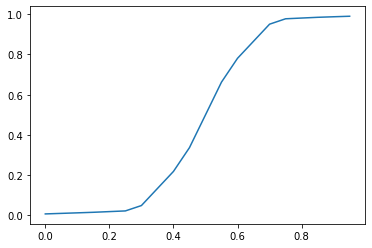

In [5]:
m = 8
Gp = ConstrainedGP(m, constraints={'increasing': True, 'bounded': [0, 1], 'convex': False}, interval=[0, 1])

# Training data
x_train = np.array([0.25, 0.5, 0.75])
y_train = np.array([0.02275013, 0.5, 0.97724987])

Gp.fit_gp(x_train, y_train, n=20, burn_in=50, method='HMC')

x_test = np.arange(0, 1, 0.05)
y_pred = Gp.mean(x_test)

plt.plot(x_test, y_pred)
plt.show()